In [238]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from textwrap import wrap

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_theme(style="darkgrid", palette="colorblind")
sns.set(rc={"figure.figsize": (11.5, 8.5), "figure.dpi": 100})

In [191]:
class Notebook:
    FIGSIZE_SMALL = (6,5)
    FIGSIZE_LARGE = (11.5, 8.5)

In [171]:
df = pd.read_hdf('data/ad.h5', 'table')

In [405]:
# Read dataset files
df = pd.read_hdf("data/sci.h5", "table")
icd10 = pd.read_hdf("data/icd10.h5", "ICD10_3_Codes")

In [364]:
icd10_chapter_dict = icd10[['Chapter_No', 'Chapter_Desc']].set_index('Chapter_No').drop_duplicates().Chapter_Desc.to_dict()
icd10_group_dict = icd10[['Group_Code', 'Group_Desc']].set_index('Group_Code').drop_duplicates().Group_Desc.to_dict()

In [406]:
# Extract ICD10 3-code and join with ICD10 table to get corresponding group and chapter per ICD10 code
df["MainICD10_3_Code"] = df.MainICD10.str[:3]
df = df.merge(
    icd10, left_on="MainICD10_3_Code", right_index=True
)

### Profiling Utils

In [344]:
def sns_multi_time_series(df, x, y, hue, xlabel="", ylabel="", title="", col_wrap=3):
    g = sns.relplot(
        data=df,
        x=x,
        y=y,
        col=hue,
        hue=hue,
        kind="line",
        palette="colorblind",
        linewidth=4,
        zorder=5,
        col_wrap=col_wrap,
        height=3,
        aspect=1.35,
        legend=False,
    )

    for year, ax in g.axes_dict.items():
        # Add the title as an annotation within the plot
        ax.text(0, 1.05, year, transform=ax.transAxes, fontweight="bold")

        # Plot every year's time series in the background
        sns.lineplot(
            data=df,
            x=x,
            y=y,
            units=hue,
            estimator=None,
            legend=False,
            color=".7",
            linewidth=1,
            ax=ax,
        )

    # Tweak the supporting aspects of the plot
    g.set_titles("")
    g.set_axis_labels(xlabel, ylabel)
    g.tight_layout()
    g.fig.subplots_adjust(top=0.88)
    g.fig.suptitle(title)
    

    return g


In [345]:
def band_proportions_periodic(df: pd.DataFrame, col, title="", period="M", subset=[]):
    quarter_sums = (
        df.groupby([df.AdmissionDateTime.dt.to_period(period), col])
        .size()
        .sum(level=0)
        .rolling(4)
        .sum()
    )

    df = (
        df.groupby([col, df.AdmissionDateTime.dt.to_period(period)])
        .size()
        .groupby(level=0, group_keys=False)
        .rolling(4)
        .sum()
    )
    df.index = df.index.droplevel(0)

    df = df.div(quarter_sums).to_frame("Proportion").reset_index()
    df.Proportion *= 100
    df.AdmissionDateTime = df.AdmissionDateTime.dt.to_timestamp()
    df = df[df[col] != 'nan']
    if len(subset):
        df = df[df[col].isin(subset)]

    return sns_multi_time_series(
        df,
        "AdmissionDateTime",
        "Proportion",
        col,
        xlabel="Admission",
        ylabel="Proportion (%)",
        title=title
    )


## Admission Statistics

In [211]:
def total_admissions(df: pd.DataFrame, start="2014-01-01", stop="2022-06-01"):
    df = df[df.AdmissionDateTime.between(start, stop)]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Total Admissions")

    df.groupby(df.AdmissionDateTime.dt.year).size().plot.bar(ax=ax[0], xlabel="Year")
    df.groupby(df.AdmissionDateTime.dt.month).size().plot.bar(ax=ax[1], xlabel="Month")

    return ax


array([<AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Month'>],
      dtype=object)

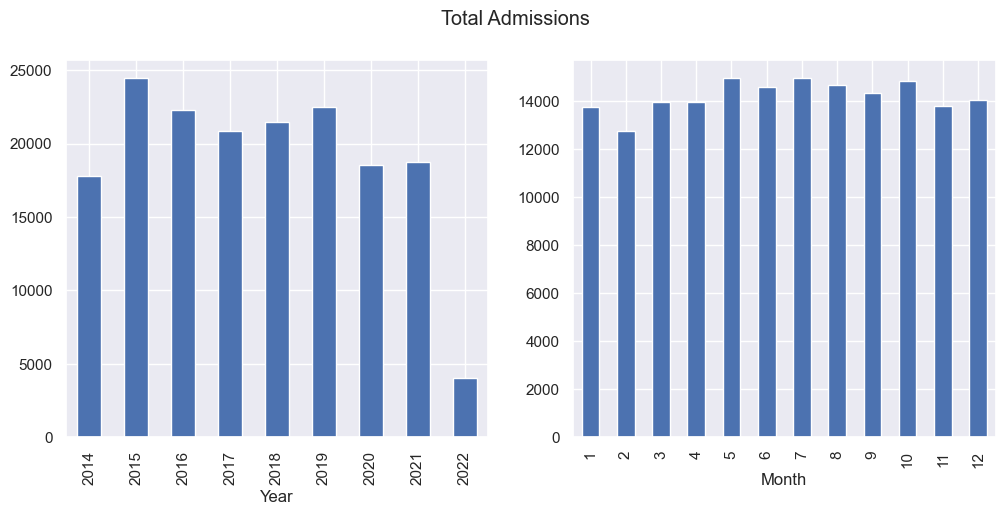

In [212]:
total_admissions(df, start="2014-01-01", stop="2022-06-01")

In [213]:
def admissions_during_year(df: pd.DataFrame):
    year_min, year_max = (
        df.AdmissionDateTime.dt.year.min(),
        df.AdmissionDateTime.dt.year.max(),
    )

    df = (
        df.groupby(
            [df.AdmissionDateTime.dt.year, df.AdmissionDateTime.dt.isocalendar().week]
        )
        .size()
        .drop(53, level=1)
    )

    try:
        df.loc[year_min, 52] += df.loc[year_min, 1]
        df.loc[year_max, 1] += df.loc[year_max, 52]
        df.loc[year_min, 1], df.loc[year_max, 52] = np.nan, np.nan
    except KeyError:
        pass

    df = df.rolling(4).sum()  # .unstack(level=0)

    df = df.to_frame(name="Admissions").reset_index()
    sns_multi_time_series(
        df,
        "week",
        "Admissions",
        "AdmissionDateTime",
        xlabel="Week",
        ylabel="Admissions",
        title=f"Monthly total admissions (rolling) per year",
    )

    # ax = sns.lineplot(data=df[years])
    # ax.set(
    #     xlabel="Week",
    #     ylabel="Admissions",
    #     title=f"Monthly admissions (rolling) during {min(years)} - {max(years)}",
    # )
    # ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)

    # return ax


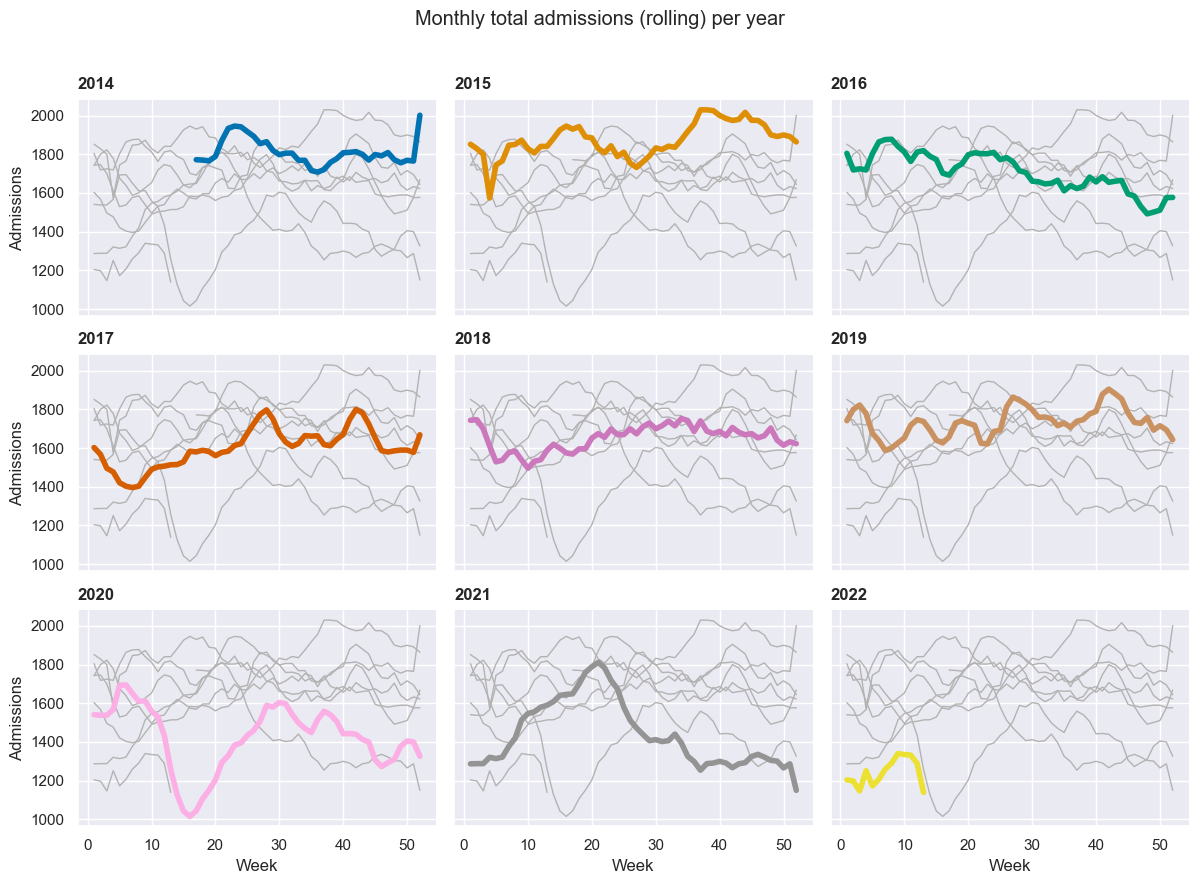

In [328]:
admissions_during_year(df)

In [215]:
def quarterly_admissions_rolling(df: pd.DataFrame):
    return (
        df.groupby(df.AdmissionDateTime.dt.to_period("M"))
        .size()
        .rolling(4)
        .sum()
        .plot(xlabel='Year', ylabel='Admissions', title='Quarterly total admissions (rolling)', figsize=Notebook().FIGSIZE_SMALL)
    )

<AxesSubplot:title={'center':'Quarterly total admissions (rolling)'}, xlabel='Year', ylabel='Admissions'>

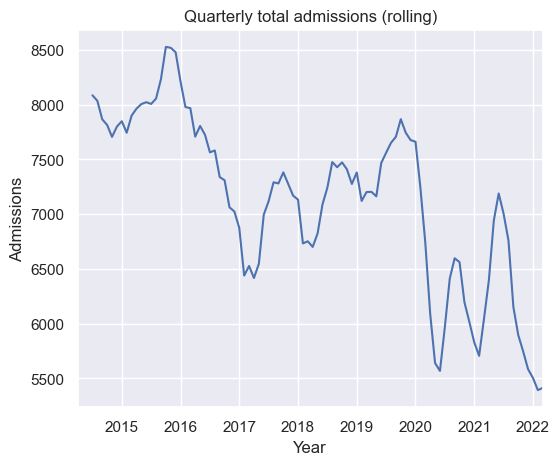

In [216]:
quarterly_admissions_rolling(df)

In [217]:
def elective_admissions_proportion_yearly(df: pd.DataFrame):
    df = df.groupby([df.AdmissionDateTime.dt.year, df.ElectiveAdmission]).size()
    df = (df.xs(True, level=1)/df.sum(level=0))

    ax = (df*100).plot.bar(xlabel='Year', ylabel='Elective Admissions (%)', figsize=Notebook.FIGSIZE_SMALL)
    ax.set(title="Proportion of elective admissions per year")

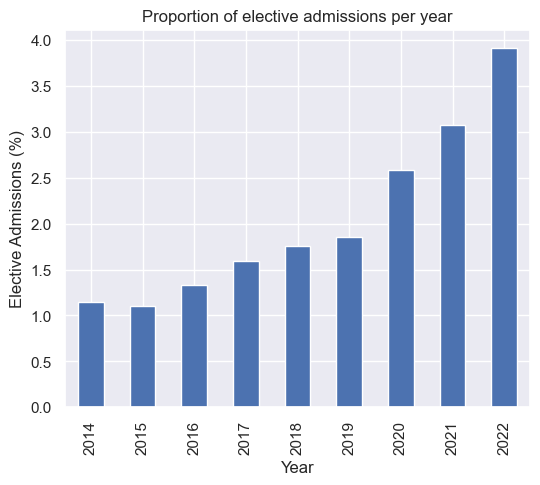

In [218]:
elective_admissions_proportion_yearly(df)

## Age Statistics

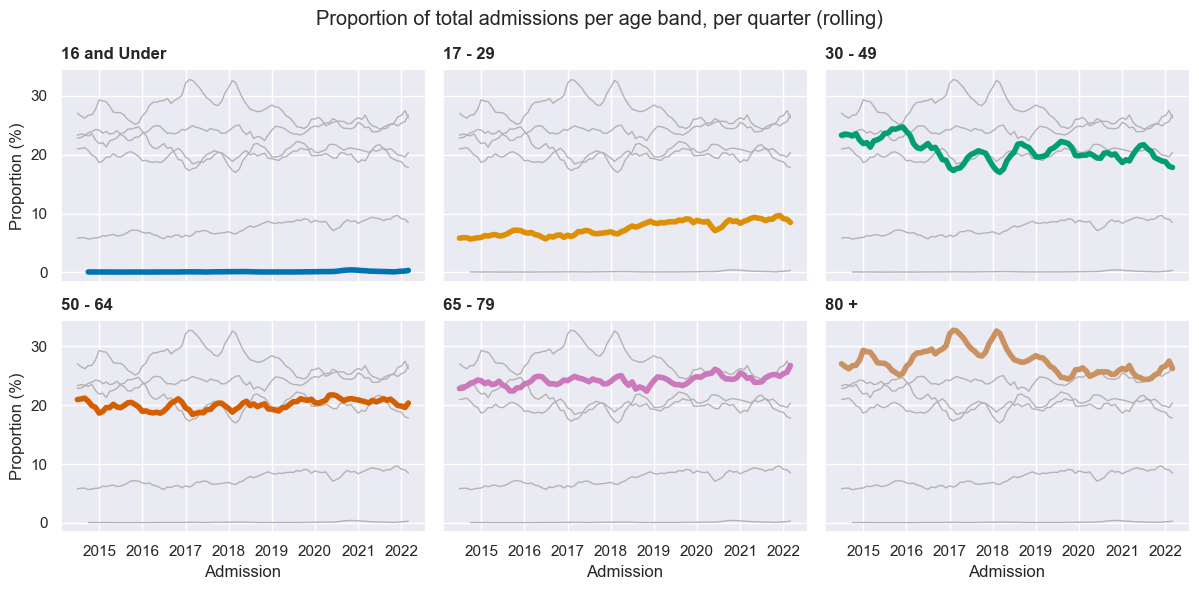

In [349]:
band_proportions_periodic(df, 'AgeBand', title="Proportion of total admissions per age band, per quarter (rolling)")

## ICD-10 Statistics

In [417]:
def diag_topn_monthly(df, icd10, since=2019, topn=9, topn_since=2019):
    df = df[df.AdmissionDateTime.dt.year >= since].copy()
    df['Group_Label'] = df.Group_Code + ' ' + df.Group_Desc.str[:27] + '...'

    top_groups = df[df.AdmissionDateTime.dt.year > topn_since]['Group_Label'].value_counts().nlargest(topn).index
    
    g = band_proportions_periodic(df, 'Group_Label', subset=top_groups, title=f'Top {topn} ICD-10 groups by proportion since {since}')
    g.axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    g.axes[0].set_xticks(g.axes[0].get_xticks()[::2])
    
    return g

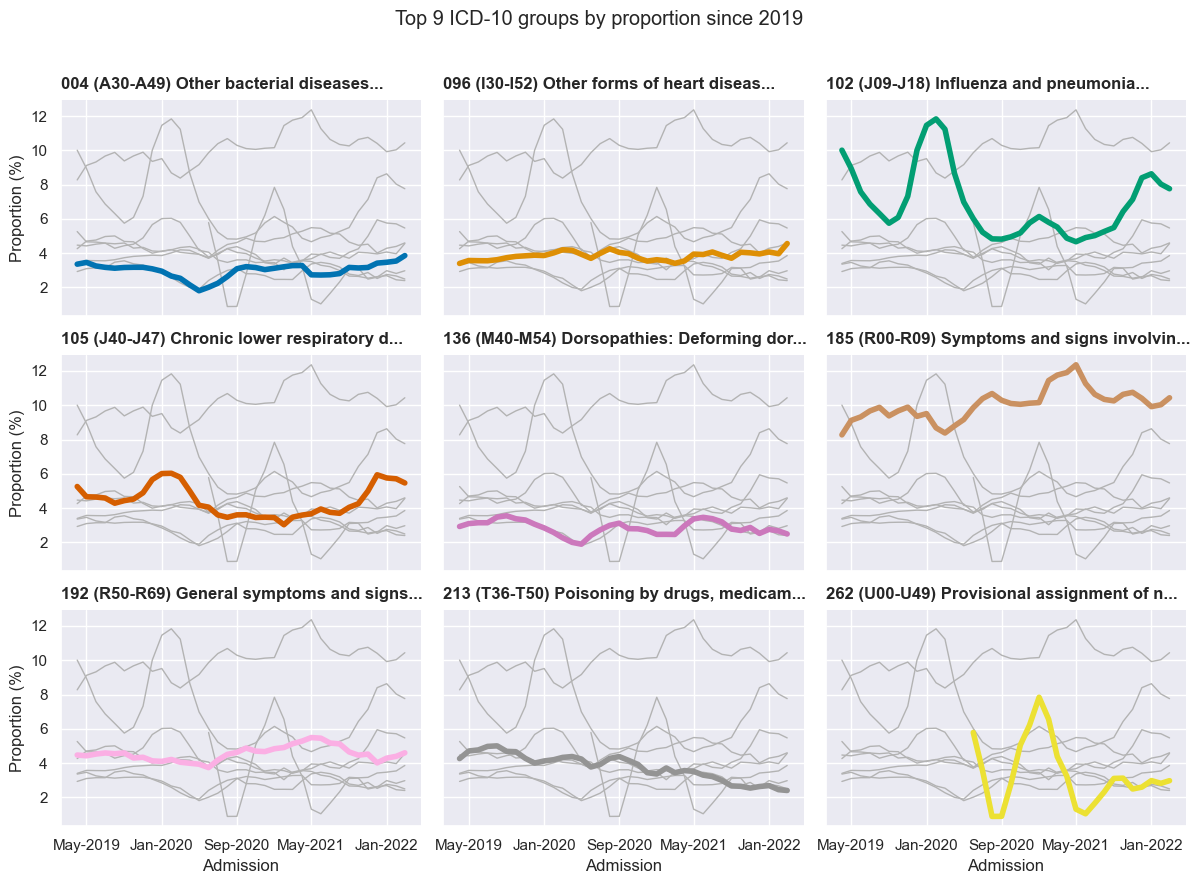

In [418]:
diag_topn_monthly(df, icd10, since=2019)

In [437]:
def topn_icd_in_year(df, icd10, datestart, dateend, topn=5, label_dict=icd10_group_dict):
    merged = df[df.AdmissionDateTime.between(datestart, dateend)]
    # Get proportions per opcode during the chosen year
    g = merged.groupby(
        [merged.Group_Code, merged.MainICD10_3_Code]
    ).SpellSerial.count()
    g = (g / g.sum())

    # Get the top groups for the year
    top_groups = g.sum(level=0).nlargest(topn).to_frame().reset_index()
    top_groups["MainICD10_3_Code"] = top_groups.Group_Code

    g = (
        g.loc[top_groups.Group_Code]
        .groupby(level=0, group_keys=False)
        .nlargest(topn)
        .reset_index()
    )
    g = pd.concat([top_groups, g])
    g.SpellSerial *= 100

    g = g.merge(icd10[['Group_Code', 'Group_Desc']], right_on='Group_Code', left_on='Group_Code')
    ax = sns.barplot(
        data=g.sort_values(["Group_Code", "SpellSerial"], ascending=False),
        x="SpellSerial",
        y="MainICD10_3_Code",
        hue="Group_Desc",
        dodge=False
    )
    ax.set(
        xlabel="Annual Admissions (%)",
        ylabel="ICD-10",
        title=f"Top {topn} ICD-10 code groups by proportion of admissions during {datestart} - {dateend}",
    )
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), borderaxespad=0.)

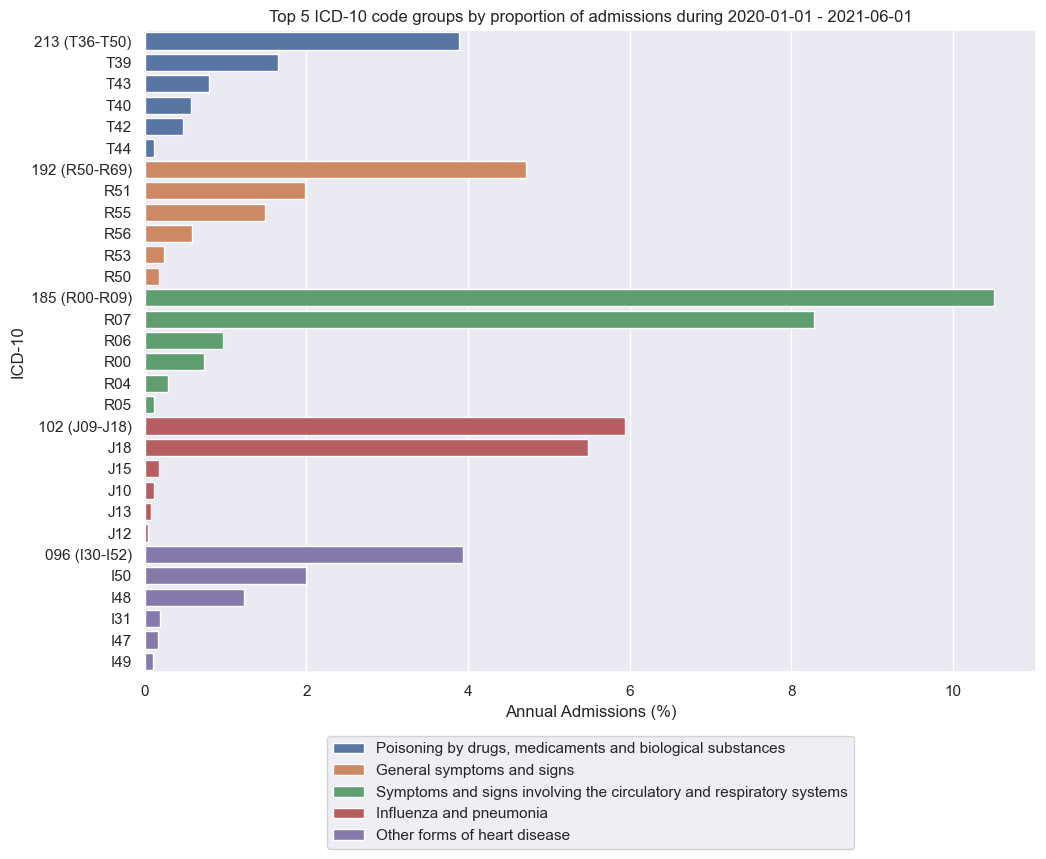

In [438]:
topn_icd_in_year(df, icd10, '2020-01-01', '2021-06-01')

In [443]:
def covid_over_time(df):
    return df[df.MainICD10_3_Code == 'U07'].groupby(
        df.AdmissionDateTime.dt.to_period('W')
    ).size().rolling(4).sum().plot(title='Admissions with U07 (Covid-19) as primary diagnosis', figsize=Notebook.FIGSIZE_SMALL)

<AxesSubplot:title={'center':'Admissions with U07 (Covid-19) as primary diagnosis'}, xlabel='AdmissionDateTime'>

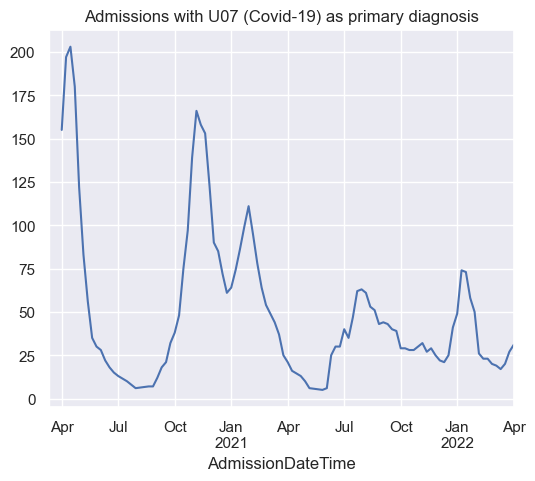

In [444]:
covid_over_time(df)

## LOS Statistics

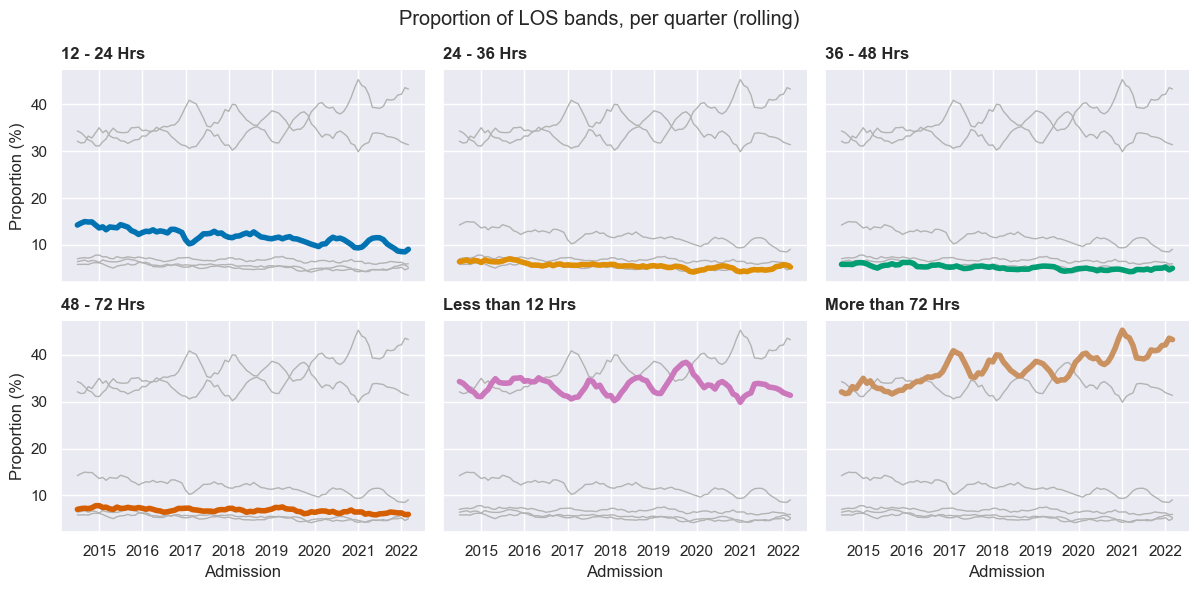

In [237]:
band_proportions_periodic(df[df.LOSBand != 'Still In'], 'LOSBand', "Proportion of LOS bands, per quarter (rolling)")

## Missing Data

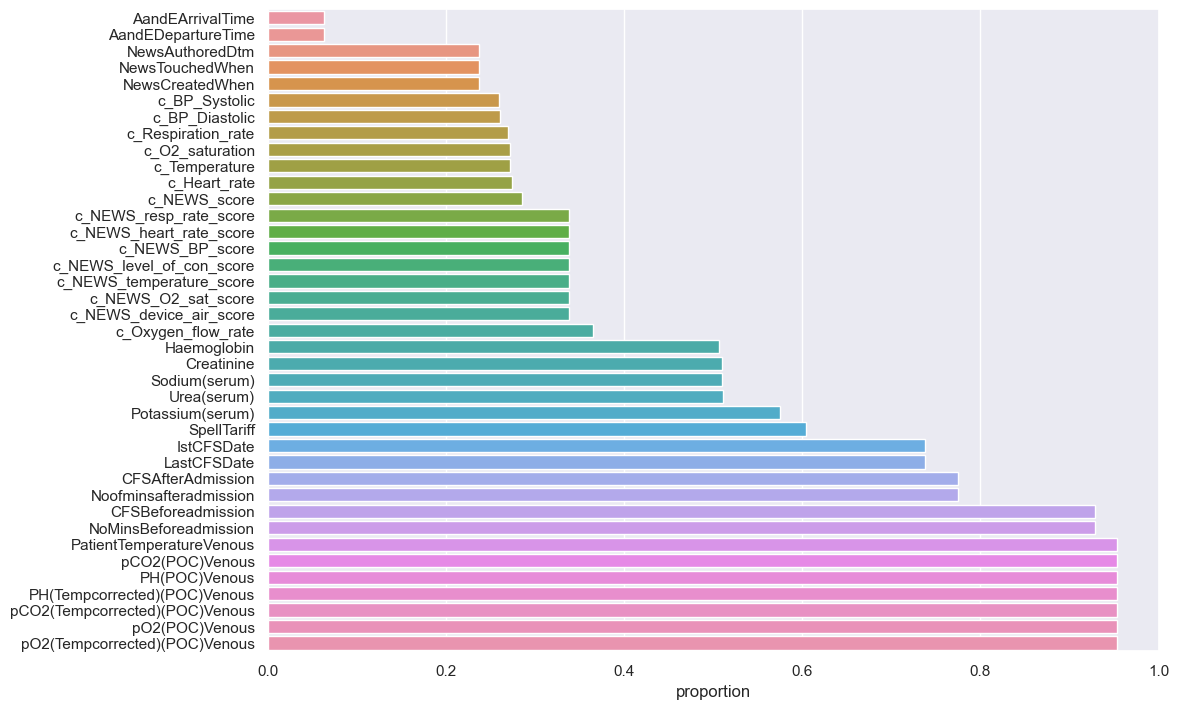

In [446]:
def missing_data(df):
    top_groups = df.groupby(df.Group_Code).size().nlargest(4).index
    missing = df.set_index(df.Group_Code).loc[top_groups]
    missing = missing.isna().sum(axis=0)/missing.shape[0]
    missing = missing[missing > 0].sort_values().to_frame(name='proportion')
    sns.barplot(data=missing, x='proportion', y=missing.index)

missing_per_icd10_grouping(df)